# Auxiliary notebook for PR 668: Tools for PSF creation.

This notebooks explains the procedure and most of the implemented functions to extract the PSFs from Kr events. and their reading.

In [1]:
import os
import glob
import numpy  as np
import pandas as pd
import tables as tb

from invisible_cities.reco.psf_functions    import create_psf
from invisible_cities.reco.psf_functions    import hdst_psf_processing
from invisible_cities.reco.psf_functions    import add_empty_sensors_and_normalize_q
from invisible_cities.reco.psf_functions    import add_variable_weighted_mean

import invisible_cities.core.core_functions as     coref
import invisible_cities.io  .dst_io         as     dstio

from invisible_cities.database              import load_db
from invisible_cities.io      .kdst_io      import psf_writer

In [2]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 16
plt.rcParams["figure.max_open_warning"] = 100

### Configuration

Initialize the different parameters for the PSF creation, hits should be created with a rebin parameter in penthesilea big enough so each SiPM charge is integrated in time.

In [3]:
### Intervals for psf
zrange     = [25, 50]

### PSF binning and range
bin_size   = 1
Xrange     = [ -50, 50]
Yrange     = [ -50, 50]
nbinX      = int(np.diff(Xrange)/bin_size)
nbinY      = int(np.diff(Yrange)/bin_size)

# Input and output path
psf_path   = '/home/lior/NEXT/Software/data/Lucy/Kr_Data/psf/'
hits_path  = '/home/lior/NEXT/Software/data/Lucy/Kr_Data/hits/integral/'

out_psf  = psf_path + 'PSF_notebook_PR.h5'

# Other parameters, not strictly necessary for the PSF but used in the notebook.
nsectors = 1
xstep    = np.linspace(-200, 200, nsectors + 1)
ystep    = np.linspace(-200, 200, nsectors + 1)
run      = 7473

### Create the PSF and write it to file

In [4]:
with tb.open_file(out_psf, 'w') as outfile:
    # Declare the PSF writer
    writer = psf_writer(outfile)
    
    # Load the hdst file, drop info not needed.
    #dsts   = dstio.load_dst(ifile, 'RECO', 'Events').drop(['Xrms', 'Yrms', 'Qc', 'Ec', 'track_id'], axis='columns').reset_index(drop=True)
    dsts   = dstio.load_dsts(sorted(glob.glob(hits_path + f'kr*r{run}.h5'))[:5], 'RECO', 'Events').drop(['Xrms', 'Yrms', 'Qc', 'Ec', 'track_id'], axis='columns').reset_index(drop=True)
    print(f'{dsts.event.nunique()} events')
    # Choose events occuring in the Z range where the PSF is to be extracted
    sel    = coref.in_range(dsts.Z, zrange[0], zrange[1]) 
    
    # Preprocess the data before extracting the PSF
    hdsts  = coref.timefunc(hdst_psf_processing)(dsts[sel], [Xrange, Yrange], 'new', run)
    
    # Safety check (single sipm events not considered to be physical)
    hdsts  = hdsts[hdsts.nsipm > 1]
    
    # Loop to extract the PSF in different regions. 
    # In this notebook, xstep and ystep are set to have just one region.
    for i, xx in enumerate(xstep[:-1]):
        for j, yy in enumerate(ystep[:-1]):
            hdst = hdsts[coref.in_range(hdsts.Xpeak, xx, xstep[i+1]) & coref.in_range(hdsts.Ypeak, yy, ystep[j+1])]
            
            # Create the PSF with the relative position and normalized charge values.
            psf_new, entries_new, bins_new = coref.timefunc(create_psf)((hdst.RelX.values, hdst.RelY.values), hdst.NormQ, 
                                                         [nbinX, nbinY], [Xrange, Yrange])
            xpsf, ypsf = (xx+xstep[i+1])/2, (yy+ystep[j+1])/2 
            
            # Write the PSF to file. 
            # The PSF is created through a histogram which returns a 2D array in inverted XY axis order, thus the transpose.
            writer(bins_new[0], bins_new[1], [0], np.floor(xpsf), np.floor(ypsf), sum(zrange)/2, 
                   np.asarray([psf_new]).transpose((1, 2, 0)), np.asarray([entries_new]).transpose((1, 2, 0)))

266877 events
Time spent in hdst_psf_processing: 202.68103909492493 s
Time spent in create_psf: 0.1457047462463379 s


### Read the PSF

In [5]:
psf =  dstio.load_dst(out_psf, 'PSF', 'PSFs')

In [6]:
psf.head()

,nevt,xr,yr,zr,x,y,z,factor
0,138,-49.5,-49.5,0.0,0.0,0.0,37.5,0.000009
1,117,-49.5,-48.5,0.0,0.0,0.0,37.5,0.000012
2,115,-49.5,-47.5,0.0,0.0,0.0,37.5,0.000000
3,108,-49.5,-46.5,0.0,0.0,0.0,37.5,0.000000
4,107,-49.5,-45.5,0.0,0.0,0.0,37.5,0.000034


/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.
  del sys.path[0]


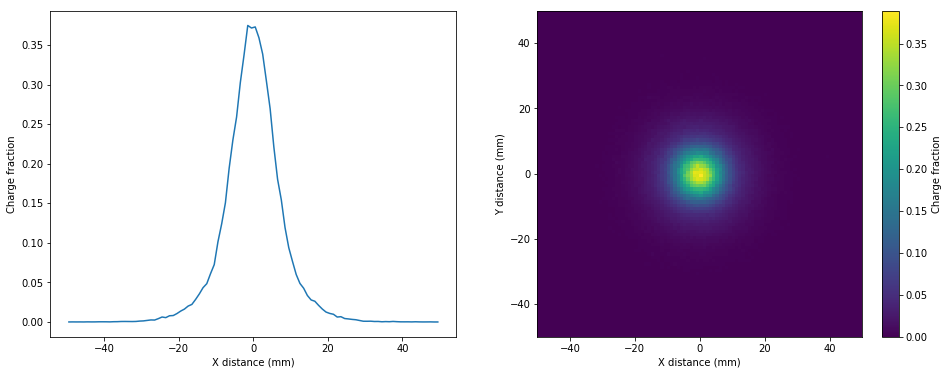

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

### Plot PSF at center (X dimension)
p1 = psf[(psf.z==37.5) & (psf.yr==0.5)]
x, y = sorted(set(p1.xr)), p1.groupby(['xr'])['factor'].sum().values
axes[0].plot(x, y)
axes[0].set_xlabel('X distance (mm)')
axes[0].set_ylabel('Charge fraction')

### PSF (2D)
p1 = psf[(psf.z==37.5)]
x, y, e = p1.xr.values, p1.yr.values, p1.factor.values
xb, yb  = np.linspace(*Xrange, np.diff(Xrange)+1), np.linspace(*Yrange, np.diff(Yrange)+1)
img = axes[1].hist2d(x, y, bins=[xb,yb], weights=e)
axes[1].set_xlabel('X distance (mm)')
axes[1].set_ylabel('Y distance (mm)')
cb = fig.colorbar(img[3], ax=axes[1])

cb.set_label('Charge fraction')

### Function by function

Show the behavior and performance of each of the involved functions.

##### Choose individual event to use as example

In [8]:
dst = dsts[dsts.event==dsts.event.unique()[0]]
dst.head()

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Z,Q,E
0,1,1.566758e+09,0,-71.633853,-149.739806,1,-75.0,-145.0,479.814437,87.454086,1462.447103
1,1,1.566758e+09,0,-71.633853,-149.739806,1,-75.0,-155.0,479.814437,76.391197,1277.448427
2,1,1.566758e+09,0,-71.633853,-149.739806,1,-65.0,-145.0,479.814437,48.411072,809.552013
3,1,1.566758e+09,0,-71.633853,-149.739806,1,-65.0,-155.0,479.814437,45.829212,766.376980
4,1,1.566758e+09,0,-71.633853,-149.739806,1,-85.0,-155.0,479.814437,39.429626,659.360190


##### Measure the weighted average of a variable in the dataframe

`add_variable_weighted_mean` calculates the average of a given variable of a dataframe weighted by another variable of the same dataframe. In the PSF building, only needed for a 3D PSF though this approach is not fully implemented and will be polished in the future.

In [9]:
coref.timefunc(add_variable_weighted_mean)(dst, 'Z', 'E')

Time spent in add_variable_weighted_mean: 0.12056326866149902 s


/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [10]:
dst.head()

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Z,Q,E,Zpeak
0,1,1.566758e+09,0,-71.633853,-149.739806,1,-75.0,-145.0,479.814437,87.454086,1462.447103,479.814438
1,1,1.566758e+09,0,-71.633853,-149.739806,1,-75.0,-155.0,479.814437,76.391197,1277.448427,479.814438
2,1,1.566758e+09,0,-71.633853,-149.739806,1,-65.0,-145.0,479.814437,48.411072,809.552013,479.814438
3,1,1.566758e+09,0,-71.633853,-149.739806,1,-65.0,-155.0,479.814437,45.829212,766.376980,479.814438
4,1,1.566758e+09,0,-71.633853,-149.739806,1,-85.0,-155.0,479.814437,39.429626,659.360190,479.814438


##### Measure the weighted average of a variable in the dataframe

`add_empty_sensors_and_normalize_q` adds entries to the dataframe corresponding to sensors that are physically near the event but haven't seen any charge. These entries are added with Q=0 and are relevant to the PSF (as they should be included in the average response). The entries are added according to the database, adding SiPMs up to the choiced range (in the PSF creation the added SiPM range is that of the PSF creation range).

Then, an additional column, with the normalized Q of each sensor (to the Q sum) is added to the dataframe. This is the column that will be used to get the PSF. This means the PSF intensity is given by the mean normalized Q charge seen at a given relative position.

In [11]:
dst.tail()

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Z,Q,E,Zpeak
19,1,1.566758e+09,0,-71.633853,-149.739806,1,-95.0,-175.0,479.814437,6.439598,107.685895,479.814438
20,1,1.566758e+09,0,-71.633853,-149.739806,1,-95.0,-155.0,479.814437,5.491645,91.833789,479.814438
21,1,1.566758e+09,0,-71.633853,-149.739806,1,-75.0,-125.0,479.814437,5.386807,90.080650,479.814438
22,1,1.566758e+09,0,-71.633853,-149.739806,1,-65.0,-125.0,479.814437,5.361578,89.658759,479.814438
23,1,1.566758e+09,0,-71.633853,-149.739806,1,195.0,15.0,479.814437,5.098637,85.261734,479.814438


In [12]:
sipm_db  = load_db.DataSiPM('new', run)
dst_proc = coref.timefunc(add_empty_sensors_and_normalize_q)(dst, ['X','Y'], [Xrange, Yrange], sipm_db).reset_index(drop=True)

Time spent in add_empty_sensors_and_normalize_q: 0.023055553436279297 s


In [13]:
dst_proc.tail()

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Z,Q,E,Zpeak,NormQ
96,1,1.566758e+09,0,-71.633853,-149.739806,24,-35.0,-165.0,479.814437,0.0,0.0,0.0,0.0
97,1,1.566758e+09,0,-71.633853,-149.739806,24,-25.0,-195.0,479.814437,0.0,0.0,0.0,0.0
98,1,1.566758e+09,0,-71.633853,-149.739806,24,-25.0,-185.0,479.814437,0.0,0.0,0.0,0.0
99,1,1.566758e+09,0,-71.633853,-149.739806,24,-25.0,-175.0,479.814437,0.0,0.0,0.0,0.0
100,1,1.566758e+09,0,-71.633853,-149.739806,24,-25.0,-165.0,479.814437,0.0,0.0,0.0,0.0


##### Process the data before creating the PSF

`hdst_psf_processing` applies both `add_empty_sensors_and_normalize_q` and `add_variable_weighted_mean` (only in 3D) to the hits dst. It also adds the relative positions (Pos - Pospeak) as they are used needed to calculate the PSF.

In [14]:
dst  = dsts[dsts.event==dsts.event.unique()[0]]
hdst = coref.timefunc(hdst_psf_processing)(dst, [Xrange, Yrange], 'new', run)

Time spent in hdst_psf_processing: 0.039453744888305664 s


In [15]:
hdst.tail()

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Z,Q,E,NormQ,Zpeak,RelZ,RelX,RelY
96,1,1.566758e+09,0,-71.633853,-149.739806,24,-35.0,-165.0,479.814437,0.0,0.0,0.0,479.814437,0.0,36.633853,-15.260194
97,1,1.566758e+09,0,-71.633853,-149.739806,24,-25.0,-195.0,479.814437,0.0,0.0,0.0,479.814437,0.0,46.633853,-45.260194
98,1,1.566758e+09,0,-71.633853,-149.739806,24,-25.0,-185.0,479.814437,0.0,0.0,0.0,479.814437,0.0,46.633853,-35.260194
99,1,1.566758e+09,0,-71.633853,-149.739806,24,-25.0,-175.0,479.814437,0.0,0.0,0.0,479.814437,0.0,46.633853,-25.260194
100,1,1.566758e+09,0,-71.633853,-149.739806,24,-25.0,-165.0,479.814437,0.0,0.0,0.0,479.814437,0.0,46.633853,-15.260194


##### Create the psf

Create the PSF with the processed hdst, with the number of bins in the given range. The function returns the PSF and the number of entries per bin, so both information can be stored.

In [16]:
psf_new, entries_new, bins_new = coref.timefunc(create_psf)((hdst.RelX.values, hdst.RelY.values), hdst.NormQ, [nbinX, nbinY], [Xrange, Yrange])

Time spent in create_psf: 0.003828287124633789 s


For a single event, the PSF and the sensor response should follow the same distribution.

Text(0.5, 1.0, 'Number of entries in the PSF bins.')

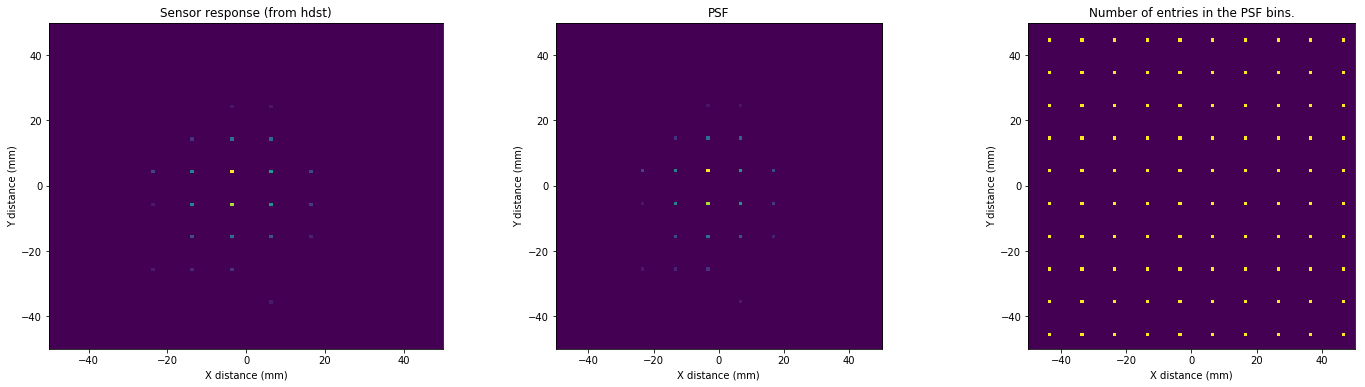

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
axes[0].hist2d(hdst.RelX, hdst.RelY, bins=[xb, yb], weights=hdst.NormQ)
axes[0].set_xlabel('X distance (mm)')
axes[0].set_ylabel('Y distance (mm)')
axes[0].set_title('Sensor response (from hdst)')
axes[1].imshow(psf_new.T, origin='lower', extent=[*Xrange, *Yrange])
axes[1].set_xlabel('X distance (mm)')
axes[1].set_ylabel('Y distance (mm)')
axes[1].set_title('PSF')
axes[2].imshow(entries_new.T, origin='lower', extent=[*Xrange, *Yrange])
axes[2].set_xlabel('X distance (mm)')
axes[2].set_ylabel('Y distance (mm)')
axes[2].set_title('Number of entries in the PSF bins.')